# Predict the cultural difference based on the ingredients

## Import library and read data from json file

In [110]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
sb.set()
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bui_quang_huy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [111]:
data = pd.read_json("train.json")


In [112]:
data.shape

(39774, 3)

## Prepare and clean the dataset

### Count the number of ingredients in each cuisine

In [113]:
data['number_ingredients'] = data['ingredients'].str.len()
data.head()


,id,cuisine,ingredients,number_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20


### Delete outliers: cuisine with less or equal to 1 ingredients and more or equal to 60 ingredients

In [114]:
data = data [data ['number_ingredients'] > 1] #delete the outliers with only 1 ingredients

In [115]:
data = data[data['number_ingredients']<60] #delete the outliers with more than 60 ingredients

### A function that changes unwanted word formats: 
<ul>
    <li> Delete invalid ingredients, apostrophes, special characters, hyphens, units, numbers </li>
    <li> Change all ingredients to lower case</li>
    <li> Use Lemmatization to remove inflectional endings and return the original/base form of a word (e.g.: Change all the "eggs" to "egg")</li>
</ul>

In [116]:
lemmatizer = WordNetLemmatizer()
def clean_data(ingredients):
    list_ingredients = ' '.join(ingredients)
    list_ingredients = list_ingredients.replace('-', ' ') # Delete character ("-")
    list_ingredients = list_ingredients.lower() #Change all the variable to Lower-case
    list_of_words = []
    for ing in list_ingredients.split():
        ing = re.sub("[0-9]"," ",ing) #removing all the invalid ingredients and/or the special characters, numbers
        ing = re.sub((r'\b(inches|ounce|ounc|lb|oz|pound|inch|kg|to)\b'), ' ', ing) # Removing Units
        if len(ing) <= 2: continue # Removing words with less than two characters, which is invalid
        ing = lemmatizer.lemmatize(ing) #Using lemmatize for the list of words of ingredients
        if len(ing) > 0: list_of_words.append(ing)
    return ' '.join(list_of_words)

In [117]:
ingredients_df = pd.DataFrame(data["ingredients"]) 
data.head()

,id,cuisine,ingredients,number_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20


### Apply the above function to our ingredients, and create new Data Frame to store new list of ingredients

In [118]:
from tqdm.notebook import tqdm
tqdm.pandas()

#### New data frame named "ingredient" will store the cleaned dataset from "ingredients"

In [119]:
data['ingredient'] = data['ingredients'].progress_apply(clean_data)

In [120]:
ingredients_df = pd.DataFrame(data["ingredients"]) 
data.head()

,id,cuisine,ingredients,number_ingredients,ingredient
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


### Split the dataset in the train set (75%) and test set (25%) randomly

In [121]:
# train_data = pd.DataFrame(data[:30000])
# test_data = pd.DataFrame(data[-9774:])
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split (data, test_size = 0.25, random_state = 42)
print("Train Set :", train_data.shape)
print("Test Set  :", test_data.shape)

Train Set : (29813, 5)
Test Set  : (9938, 5)


In [122]:
train_data.head()

,id,cuisine,ingredients,number_ingredients,ingredient
13689,45654,southern_us,"[cream cheese, boiling water, jello, chopped p...",7,cream cheese boiling water jello chopped pecan...
5474,26959,indian,"[green cardamom pods, basmati rice, vanilla ex...",5,green cardamom pod basmati rice vanilla extrac...
35434,4383,mexican,"[black beans, lime, paprika, chipotle peppers,...",17,black bean lime paprika chipotle pepper avocad...
18996,36734,indian,"[garlic paste, garam masala, salt, cashew nuts...",16,garlic paste garam masala salt cashew nut fres...
26246,24877,mexican,"[pepper, chili powder, cream cheese, cumin, ga...",13,pepper chili powder cream cheese cumin garlic ...


In [123]:
cuisines = train_data['cuisine'].value_counts().index

# Applying Machine Learning models

#### We are using 6 different machine learning models: Naive Bayes Classifier, Decision Tree Classifier, Random Forest Classifier, MLP Classifier (a type of Neural Networks model), and XGBoost (GradientBoostingClassifier)
#### We also use 3 different metrics: normal accuracy score, k-fold cross-validation score and f1-score (using classification_report function) to evaluate these machine learning models

## 1. Naive Bayes Classification Model
The Naive Bayes Classification Model is a model that uses probability of a particular of being related to a certain group, and is considered to be an independant predictor.

<b>What does this mean?</b>
In the case of our current problem that predicts the type of cuisine based on ingredients, the 'predictor' would be the ingredients. 
The Naive Bayes model assumes each predictor is unrelated to the presence of the other ingredients. For example, <b>salt</b>. Salt appears in all cuisines, but there is a higher probability of it appearing in say, indian cuisine as compared to other cuisines. Whether olive oil also appears in the same dish is irrelevant, because we are looking at the probability of salt appearing in the cuisine independantly, and predicting based off that.

Below shows a formula that describes the Naive Bayes Classification Model.
> 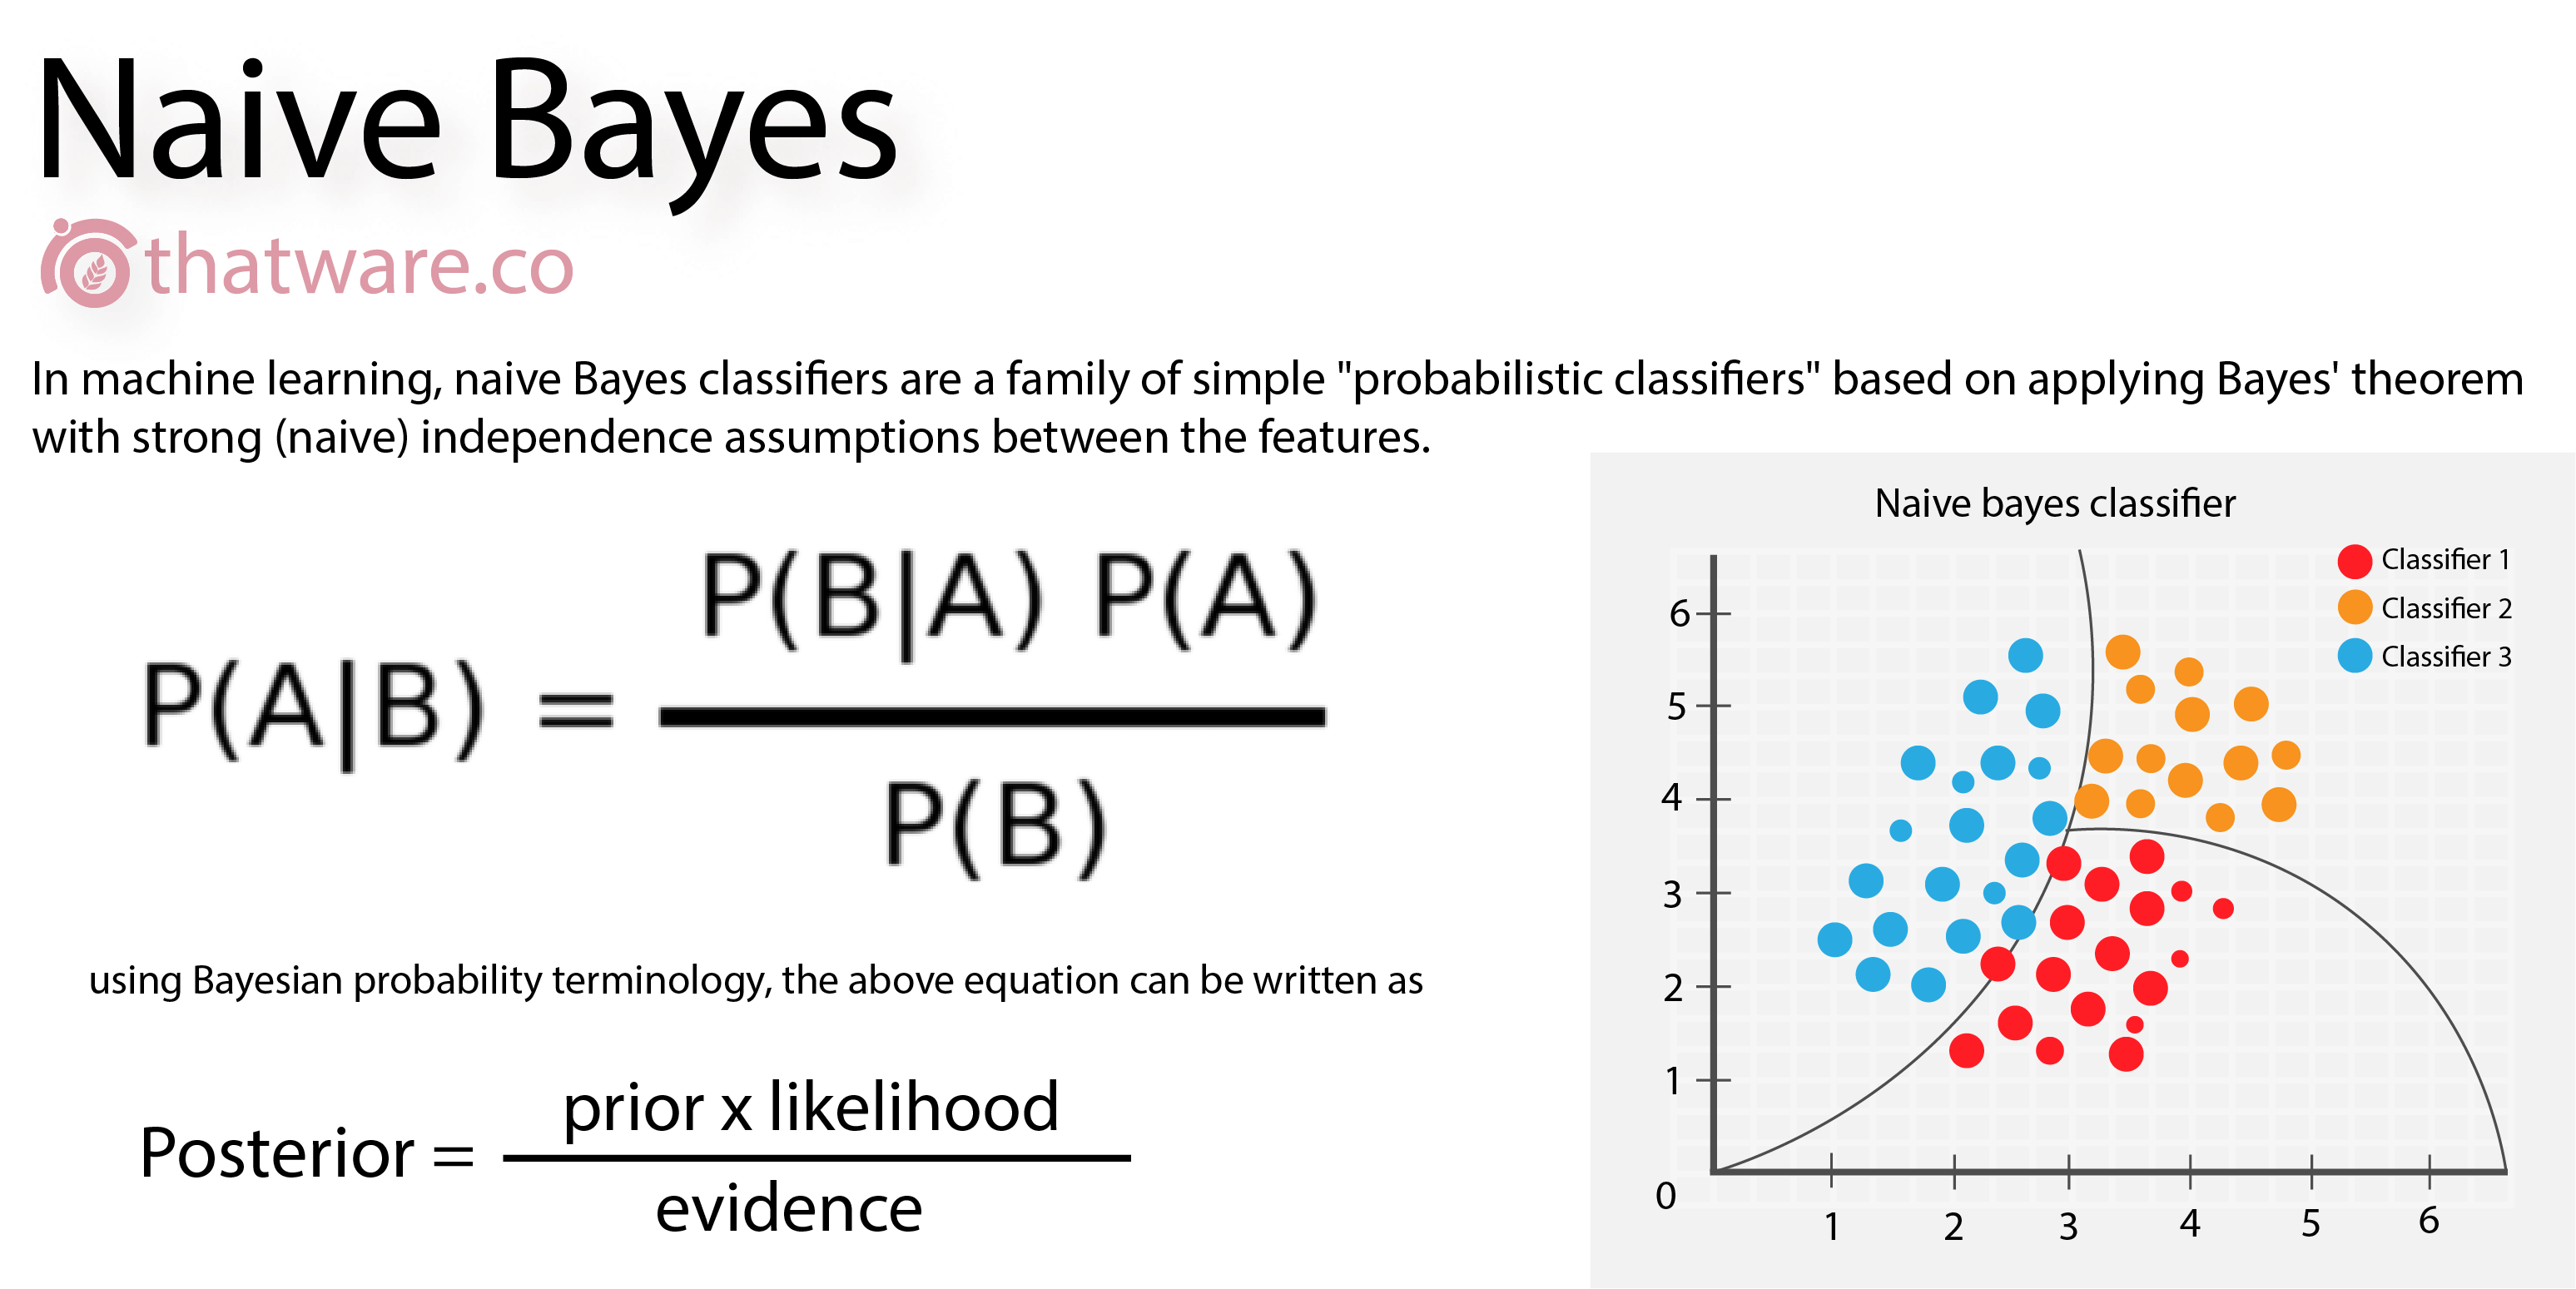

### Prepare data

In [124]:
train_data2 = train_data.copy()

In [125]:
df = train_data2[['cuisine','ingredient']]
df.head()

,cuisine,ingredient
13689,southern_us,cream cheese boiling water jello chopped pecan...
5474,indian,green cardamom pod basmati rice vanilla extrac...
35434,mexican,black bean lime paprika chipotle pepper avocad...
18996,indian,garlic paste garam masala salt cashew nut fres...
26246,mexican,pepper chili powder cream cheese cumin garlic ...


#### Change the data into the sparse matrix form
#### We use: 
<ul>
    <li> CountVectorizer to count the number of each ingredients in the list</li>
    <li> TfidfTransformer to transform the data into binary matrix form
</ul>

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

nb_count_vect = CountVectorizer()
nb_tfidf_transformer = TfidfTransformer()
X = nb_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = nb_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)


#### From now on, we will use X, the matrix, to analyze instead of the dataframes

### Apply Naive Bayes Classification model on the train dataset


In [127]:
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

#### Apply Naive Bayes model on train dataset and evaluate the accuracy based on cross-validation score

In [128]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
scores = cross_val_score(MultinomialNB(), X, df.cuisine, cv=10)
sum=0
for score in scores:
  sum+= score
print("The goodness of fit of model on the train dataset, using cross-validation score is: ", sum/10)

The goodness of fit of model on the train dataset, using cross-validation score is:  0.6649452456661022


In [129]:
mnb = MultinomialNB()
mnb.fit(X, df.cuisine)

MultinomialNB()

#### Evaluate the train accuracy based on normal score

Goodness of fit of model on the train data set, using normal score is: 	: 0.6857746620601751


<AxesSubplot:>

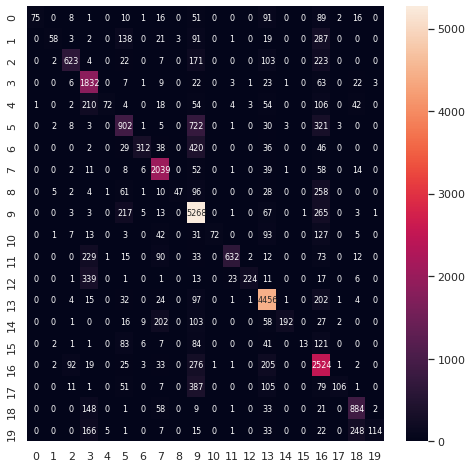

In [130]:
print("Goodness of fit of model on the train data set, using normal score is: \t:", mnb.score(X, cuisine_train))
cuisine_train_pred = mnb.predict(X)
# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [131]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.99      0.21      0.34       360
     mexican       0.81      0.09      0.17       623
 southern_us       0.80      0.54      0.65      1155
      indian       0.61      0.92      0.73      1993
      french       0.91      0.13      0.22       570
     chinese       0.55      0.45      0.50      2001
        thai       0.90      0.35      0.51       883
cajun_creole       0.77      0.91      0.84      2231
    japanese       0.94      0.09      0.17       513
       greek       0.66      0.90      0.76      5847
     spanish       0.99      0.18      0.31       394
      korean       0.94      0.58      0.71      1099
     british       0.97      0.35      0.52       636
  vietnamese       0.80      0.92      0.86      4838
    moroccan       0.97      0.31      0.48       610
    filipino       0.93      0.04      0.07       359
       irish       0.51      0.79      0.62      3184
    jamaican       0.92    

### Check the accuracy on test dataset
Since the implementation of the model on test dataset is quite similar to the train datset, I will not divide into smaller parts so that you can see more conveniently

The goodness of fit of model on the test data set, using normal score is: 	: 0.6780036224592473


<AxesSubplot:>

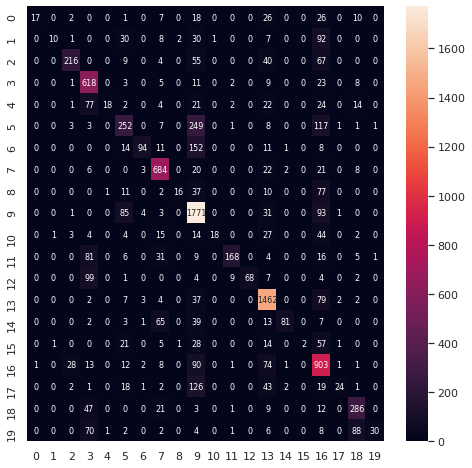

In [132]:
test_data2 = test_data.copy()
df = test_data2[['cuisine','ingredient']]

Y = nb_count_vect.transform(df.ingredient) #get the word counts for the documents in a sparse matrix form.
Y = nb_tfidf_transformer.transform(Y) #computing the ti-idf scores for your documents (tf*idf). We use transform instead of fit_transform in test data
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])
cuisine_test_pred = mnb.predict(Y)
print("The goodness of fit of model on the test data set, using normal score is: \t:", mnb.score(Y, cuisine_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_test, cuisine_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

### Create and run a function to draw a confusion matrix will all the names of the cuisines

In [133]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

Accuracy of this model is :  0.6780036224592473


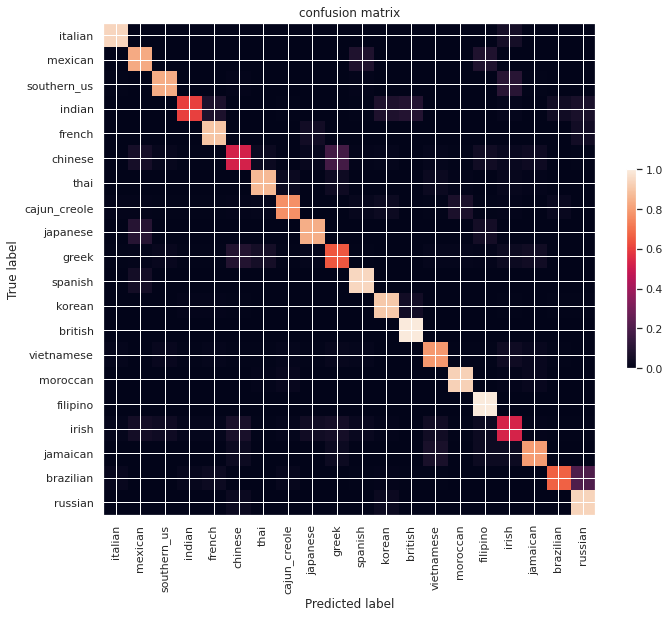

In [134]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of this model is : ", accuracy(cm))

Print f1-score - a type of metric

In [135]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))


              precision    recall  f1-score   support

     italian       0.94      0.16      0.27       107
     mexican       0.83      0.06      0.10       181
 southern_us       0.84      0.55      0.67       391
      indian       0.60      0.91      0.73       680
      french       0.90      0.10      0.18       185
     chinese       0.52      0.39      0.45       643
        thai       0.87      0.32      0.47       291
cajun_creole       0.77      0.89      0.83       766
    japanese       0.84      0.10      0.18       154
       greek       0.65      0.89      0.75      1989
     spanish       0.95      0.14      0.24       132
      korean       0.91      0.52      0.66       321
     british       1.00      0.35      0.52       194
  vietnamese       0.79      0.91      0.85      1598
    moroccan       0.93      0.38      0.54       211
    filipino       1.00      0.02      0.03       130
       irish       0.53      0.80      0.64      1135
    jamaican       0.80    

## 2. Decision Tree Classifier

The Decision Tree Classifier is something we have learnt through this EE0005 course. This classifier uses a tree that contains the gini-index, which describes how many are true in a given sample, over the total amount. Below, we can see a formula that describes the calculation of the gini-index as well.
>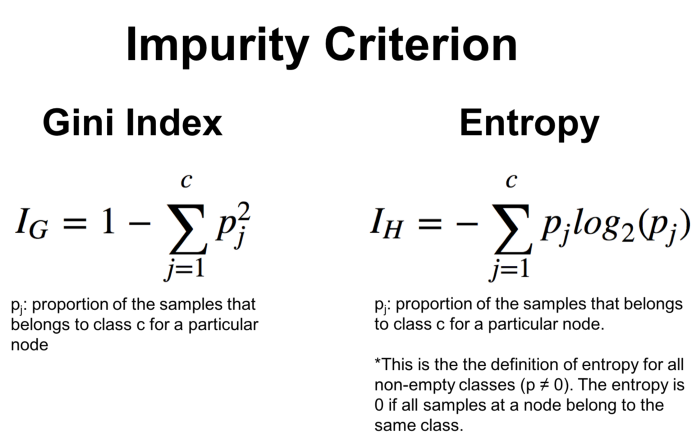


>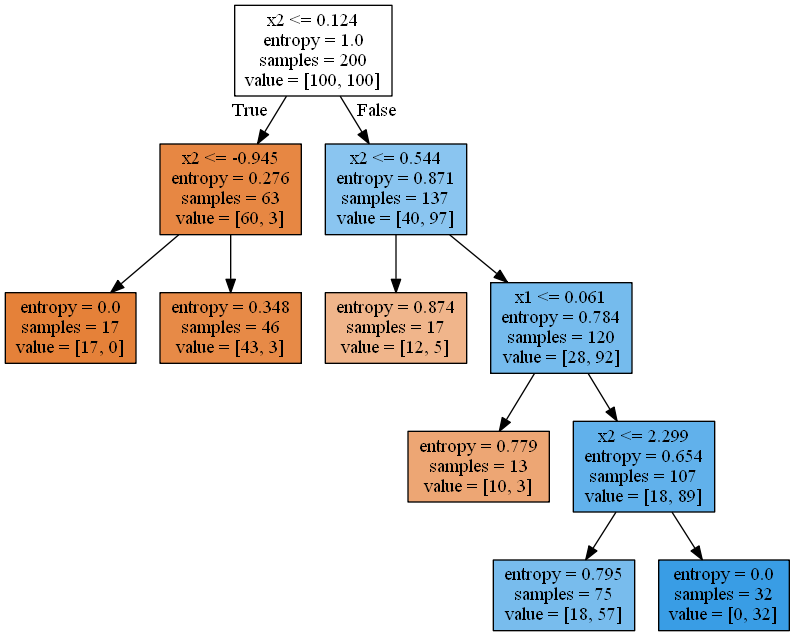


### Prepare the train dataset

In [136]:
train_data2 = train_data.copy()
df = train_data2[['cuisine','ingredient']]
df.head()

,cuisine,ingredient
13689,southern_us,cream cheese boiling water jello chopped pecan...
5474,indian,green cardamom pod basmati rice vanilla extrac...
35434,mexican,black bean lime paprika chipotle pepper avocad...
18996,indian,garlic paste garam masala salt cashew nut fres...
26246,mexican,pepper chili powder cream cheese cumin garlic ...


In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

dc_count_vect = CountVectorizer()
dc_tfidf_transformer = TfidfTransformer()
X = dc_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)

In [138]:
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

### Apply Decision Tree model and evaluate the accuracy on train dataset

The goodness of fit of Decision Tree on the train dataset, using cross-validation score is:  0.5846111008942938
The goodness of fit of Decision Tree on the train data set, using normal score is: 	: 0.7681883741991749


<AxesSubplot:>

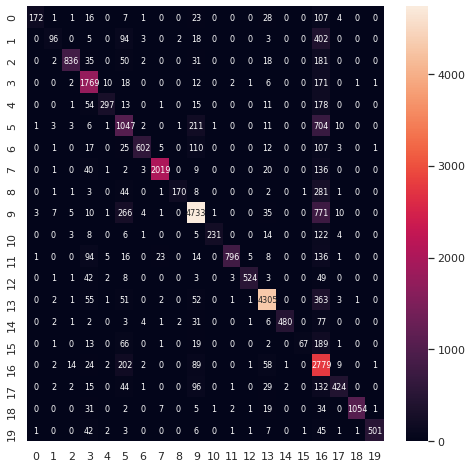

In [139]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 30)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dectree, X, df.cuisine, cv=5)
sum=0
for score in scores:
  sum+= score
print("The goodness of fit of Decision Tree on the train dataset, using cross-validation score is: ", sum/5)

dectree.fit(X, df.cuisine)
cuisine_train_pred = dectree.predict(X)
print("The goodness of fit of Decision Tree on the train data set, using normal score is: \t:", dectree.score(X, cuisine_train))
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})


In [140]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.97      0.48      0.64       360
     mexican       0.79      0.15      0.26       623
 southern_us       0.96      0.72      0.83      1155
      indian       0.78      0.89      0.83      1993
      french       0.92      0.52      0.67       570
     chinese       0.53      0.52      0.53      2001
        thai       0.96      0.68      0.80       883
cajun_creole       0.98      0.90      0.94      2231
    japanese       0.97      0.33      0.49       513
       greek       0.86      0.81      0.83      5847
     spanish       0.99      0.59      0.74       394
      korean       0.99      0.72      0.84      1099
     british       0.98      0.82      0.89       636
  vietnamese       0.94      0.89      0.91      4838
    moroccan       0.99      0.79      0.88       610
    filipino       0.97      0.19      0.31       359
       irish       0.40      0.87      0.55      3184
    jamaican       0.90    

### Check the accuracy on test dataset

Since the implementation of the model on test dataset is quite similar to the train datset, I will not divide into smaller parts so that you can see more conveniently


The goodness of fit of Decision Tree on the test dataset, using cross-validation score is:  0.5454811404916666
The goodness of fit of Decision Tree on the test data set, using normal score is: 	: 0.5946870597705776


<AxesSubplot:>

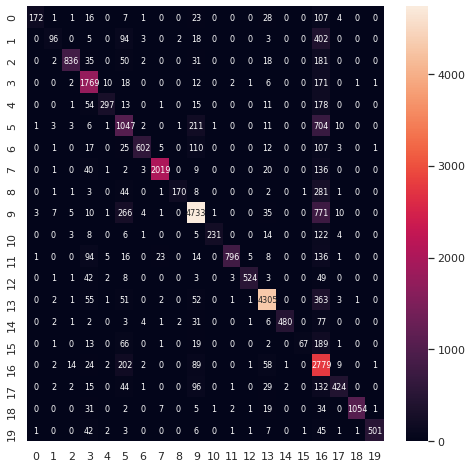

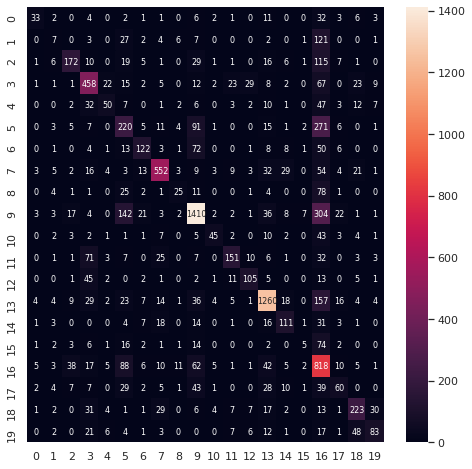

In [141]:
test_data2 = test_data.copy()
#test_data2['ingredient'] = test_data2.ingredients.map(lambda x: ' '.join(x))
df = test_data2[['cuisine','ingredient']]
X = dc_count_vect.transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])
cuisine_test_pred = dectree.predict(X) #predict the cuisine based on test data

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dectree, X, df.cuisine, cv=5)
sum=0
for score in scores:
  sum+= score
print("The goodness of fit of Decision Tree on the test dataset, using cross-validation score is: ", sum/5)
print("The goodness of fit of Decision Tree on the test data set, using normal score is: \t:", dectree.score(X, cuisine_test))
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})
from sklearn.metrics import confusion_matrix
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_test, cuisine_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [142]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.60      0.31      0.41       107
     mexican       0.13      0.04      0.06       181
 southern_us       0.66      0.44      0.53       391
      indian       0.60      0.67      0.63       680
      french       0.50      0.27      0.35       185
     chinese       0.34      0.34      0.34       643
        thai       0.60      0.42      0.49       291
cajun_creole       0.79      0.72      0.76       766
    japanese       0.44      0.16      0.24       154
       greek       0.77      0.71      0.74      1989
     spanish       0.63      0.34      0.44       132
      korean       0.67      0.47      0.55       321
     british       0.63      0.54      0.58       194
  vietnamese       0.82      0.79      0.80      1598
    moroccan       0.54      0.53      0.53       211
    filipino       0.24      0.04      0.07       130
       irish       0.34      0.72      0.47      1135
    jamaican       0.41    

Accuracy of this model is :  0.5946870597705776


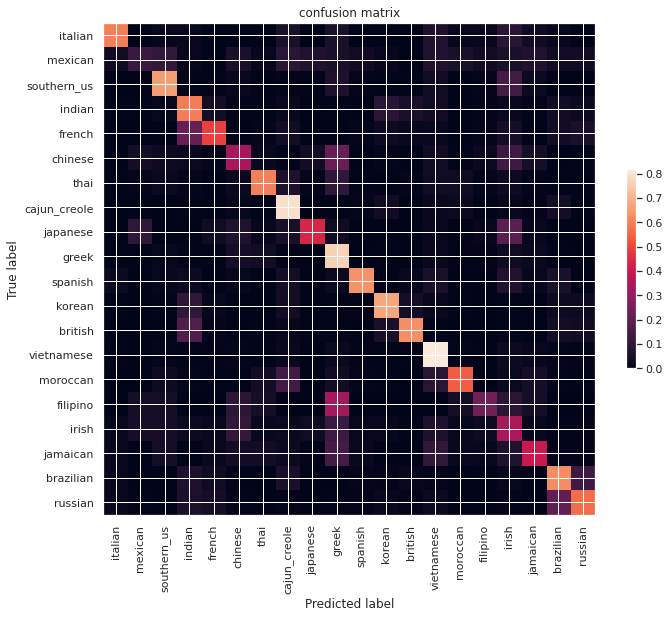

In [143]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of this model is : ", accuracy(cm))

## 3. Random Forest 

Earlier, we saw the Decision Tree Classifier, which basically used a single tree to predict the outcome. However, there is a way to even further improve this.

That is by using Random Forest, which instead of a single tree, uses multiple trees! An image showing the rough framework of how the Random Forest Classifier works can be seen as below.
>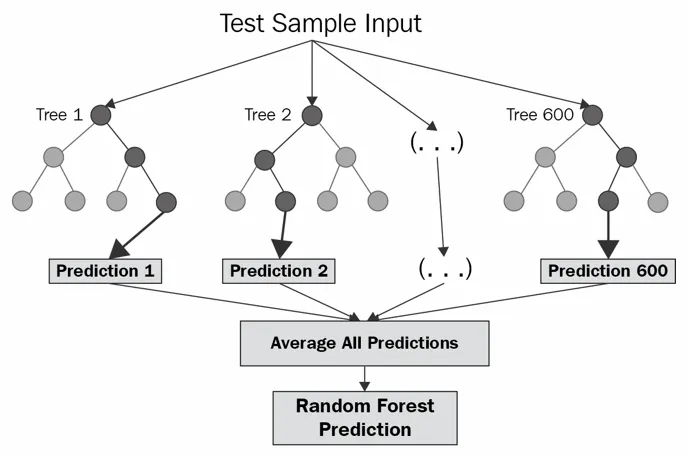

There is one important observation we can make. While the Random Tree Classifier uses multiple trees, it combines the results at the very end of the tree. Then, it decides on which is the most accurate prediction. It can determine which is the most accurate result based on 2 factors.
<ul>
    <li><b>Majority Wins</b></li>
<li><b>Averaging</b></li>
</ul>

### Prepare the dataset

In [144]:
train_data2 = train_data.copy()
#train_data2['ingredient'] = train_data2.ingredients.map(lambda x: ' '.join(x))
df = train_data2[['cuisine','ingredient']]
df.head()

,cuisine,ingredient
13689,southern_us,cream cheese boiling water jello chopped pecan...
5474,indian,green cardamom pod basmati rice vanilla extrac...
35434,mexican,black bean lime paprika chipotle pepper avocad...
18996,indian,garlic paste garam masala salt cashew nut fres...
26246,mexican,pepper chili powder cream cheese cumin garlic ...


In [145]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

rf_count_vect = CountVectorizer()
rf_tfidf_transformer = TfidfTransformer()
X = rf_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = rf_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)

### Apply Random Forest Classifier model on the train dataset and print the accuracy

In [146]:
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

The goodness of fit of model on the train dataset, using cross-validation score is:  0.6322075081925029
The goodness of fit of model on the train data set, using normal score is: 	: 0.9701137087847583


<AxesSubplot:>

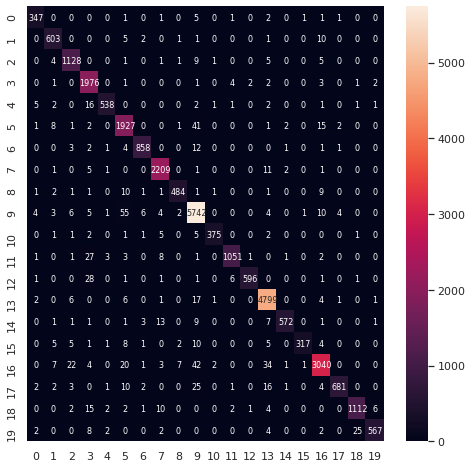

In [147]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=5)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, df.cuisine, cv=5)
sum=0
for score in scores:
   sum+= score
print("The goodness of fit of model on the train dataset, using cross-validation score is: ", sum/5)

rf.fit(X, df.cuisine)
cuisine_train_pred = rf.predict(X)
print("The goodness of fit of model on the train data set, using normal score is: \t:", rf.score(X, cuisine_train))
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})


In [148]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.95      0.96      0.96       360
     mexican       0.94      0.97      0.95       623
 southern_us       0.96      0.98      0.97      1155
      indian       0.94      0.99      0.97      1993
      french       0.98      0.94      0.96       570
     chinese       0.94      0.96      0.95      2001
        thai       0.98      0.97      0.98       883
cajun_creole       0.98      0.99      0.98      2231
    japanese       0.97      0.94      0.96       513
       greek       0.97      0.98      0.98      5847
     spanish       0.98      0.95      0.97       394
      korean       0.99      0.96      0.97      1099
     british       0.99      0.94      0.96       636
  vietnamese       0.98      0.99      0.99      4838
    moroccan       0.99      0.94      0.96       610
    filipino       0.99      0.88      0.93       359
       irish       0.98      0.95      0.97      3184
    jamaican       0.99    

### Apply Random Forest Classifier on the test data

In [149]:
test_data2 = test_data.copy()
#test_data2['ingredient'] = test_data2.ingredients.map(lambda x: ' '.join(x))
df = test_data2[['cuisine','ingredient']]
X = rf_count_vect.transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = rf_tfidf_transformer.transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])
cusine_test_pred = rf.predict(X)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, df.cuisine, cv=5)
sum=0
for score in scores:
  sum+= score
print("The goodness of fit of model on the test dataset, using cross-validation score is: ", sum/5)

The goodness of fit of model on the test dataset, using cross-validation score is:  0.5777818395020349


<AxesSubplot:>

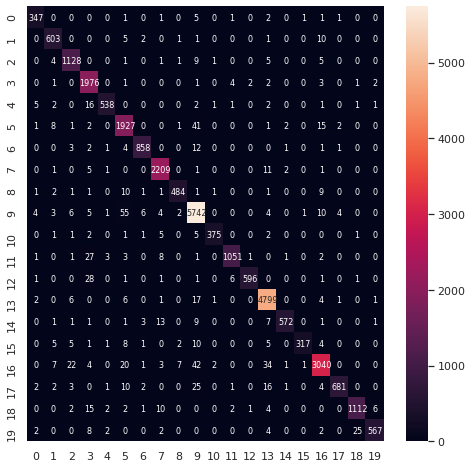

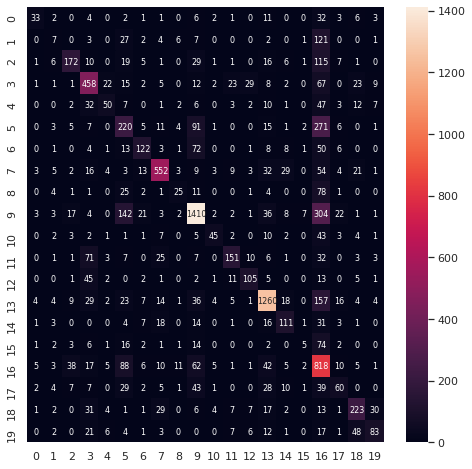

In [150]:
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})
from sklearn.metrics import confusion_matrix
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_test, cuisine_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [151]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.60      0.31      0.41       107
     mexican       0.13      0.04      0.06       181
 southern_us       0.66      0.44      0.53       391
      indian       0.60      0.67      0.63       680
      french       0.50      0.27      0.35       185
     chinese       0.34      0.34      0.34       643
        thai       0.60      0.42      0.49       291
cajun_creole       0.79      0.72      0.76       766
    japanese       0.44      0.16      0.24       154
       greek       0.77      0.71      0.74      1989
     spanish       0.63      0.34      0.44       132
      korean       0.67      0.47      0.55       321
     british       0.63      0.54      0.58       194
  vietnamese       0.82      0.79      0.80      1598
    moroccan       0.54      0.53      0.53       211
    filipino       0.24      0.04      0.07       130
       irish       0.34      0.72      0.47      1135
    jamaican       0.41    

Accuracy of this model is :  0.5946870597705776


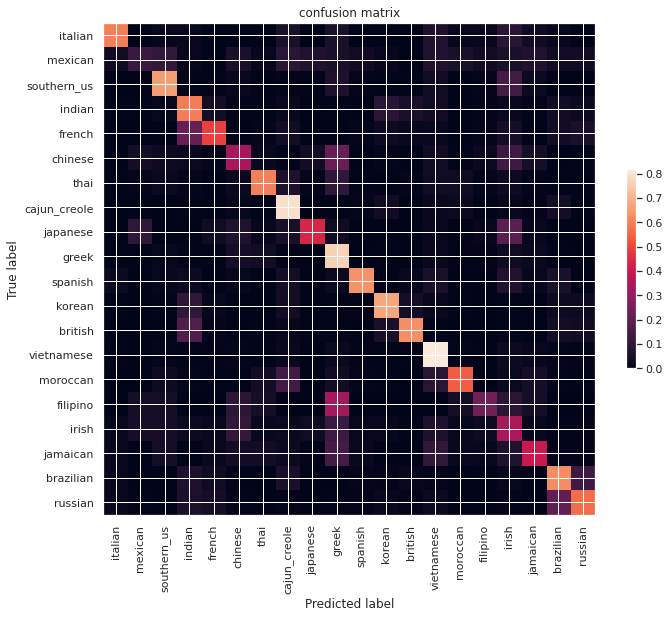

In [152]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of Random Forest model on test data is : ", accuracy(cm))

## 4. Neural Network - MLP Classifier
The MLP Classifier, can be compared to the Naive Bayes Model. However, there is a difference. Both are carrying out the task of classification, but the MLP Classifier uses a <b>Neural Network Model</b> to carry out this task of classification. 

>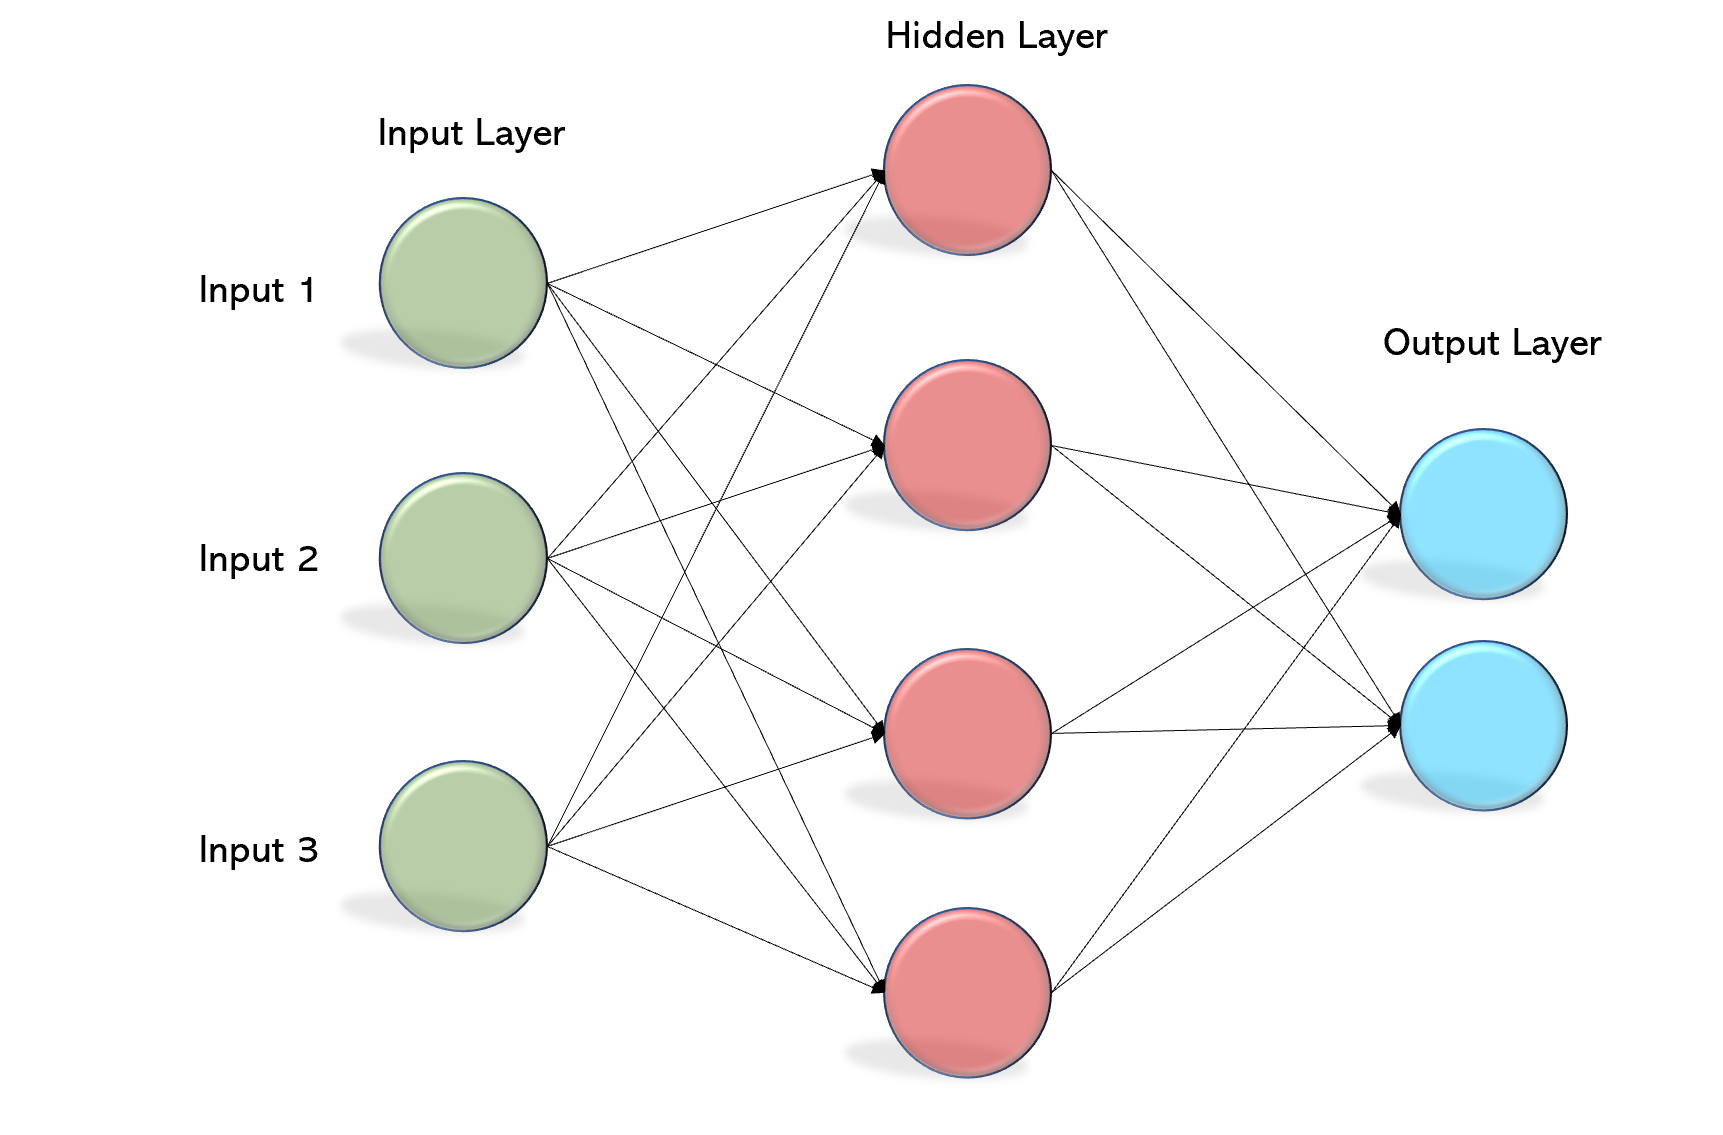

<b>But what does a Neural Network Mean?</b>

According to the https://www.ibm.com/cloud/learn/neural-networks
Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

Looking at the above picture, and the description, we can find out what it does. The picture shows the <b>input layer</b>, which would be our ingredients in this What's Cooking Dataset. The hidden layer, however, is slightly more complicated. This following paragraph is an extract from https://stats.stackexchange.com/questions/63152/what-does-the-hidden-layer-in-a-neural-network-compute that explains how the Hidden Layer works quite well.

<i>If you want a computer to tell you if there's a bus in a picture, the computer might have an easier time if it had the right tools.

So your bus detector might be made of a wheel detector (to help tell you it's a vehicle) and a box detector (since the bus is shaped like a big box) and a size detector (to tell you it's too big to be a car). These are the three elements of your hidden layer: they're not part of the raw image, they're tools you designed to help you identify busses.

If all three of those detectors turn on (or perhaps if they're especially active), then there's a good chance you have a bus in front of you.

Neural nets are useful because there are good tools (like backpropagation) for building lots of detectors and putting them together.</i>

In the context of our What's Cooking Dataset, the hidden layer could contain information such as the following. Note that these are just examples of the type of information that this hidden layer could hold, and is not a 100% accurate representation of the exact type of data contained in the hidden layer.

<b>Is the ingredient a unique ingredient that only belongs to one cuisine?</b>

<b>Is the frequency of the ingredient occuring in a particular cuisine higher as compared to another cuisine?</b>


### Apply MLP Classifier on train dataset and evaluate the accuracy (it may take 10-15 minutes to complete)


In [153]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier (solver = 'adam', alpha=0.001, hidden_layer_sizes=(100,100,100), random_state=1, activation='logistic' ,early_stopping = True);

In [154]:
train_data2 = train_data.copy()
#train_data2['ingredient'] = train_data2.ingredients.map(lambda x: ' '.join(x))
df = train_data2[['cuisine','ingredient']]
df.head()

,cuisine,ingredient
13689,southern_us,cream cheese boiling water jello chopped pecan...
5474,indian,green cardamom pod basmati rice vanilla extrac...
35434,mexican,black bean lime paprika chipotle pepper avocad...
18996,indian,garlic paste garam masala salt cashew nut fres...
26246,mexican,pepper chili powder cream cheese cumin garlic ...


#### Prepare the dataset

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

dc_count_vect = CountVectorizer()
dc_tfidf_transformer = TfidfTransformer()
X = dc_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)

In [156]:
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

#### Train the model and evaluate the accuracy

In [157]:
clf.fit(X, df.cuisine)
cuisine_train_pred = clf.predict(X)

<AxesSubplot:>

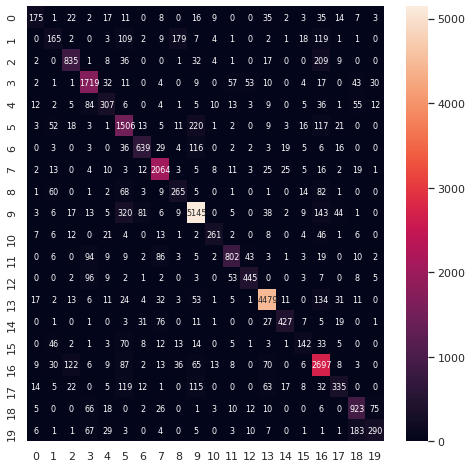

In [158]:
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [159]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cuisine_train_pred, cuisine_train)
print("Accuracy of MLPClassifier using normal score is : ", accuracy(cm))

Accuracy of MLPClassifier using normal score is :  0.7923053701405427


In [160]:
scores = cross_val_score(clf, X, df.cuisine, cv=5)

In [161]:
sum=0
for score in scores:
   sum+= score
print("Accuracy of MLPClassifier on train dataset using cross validation score is:", sum/5)

Accuracy of MLPClassifier on train dataset using cross validation score is: 0.7235771997315662


In [162]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.68      0.49      0.57       360
     mexican       0.41      0.26      0.32       623
 southern_us       0.78      0.72      0.75      1155
      indian       0.79      0.86      0.83      1993
      french       0.62      0.54      0.57       570
     chinese       0.62      0.75      0.68      2001
        thai       0.79      0.72      0.75       883
cajun_creole       0.86      0.93      0.89      2231
    japanese       0.50      0.52      0.51       513
       greek       0.88      0.88      0.88      5847
     spanish       0.82      0.66      0.73       394
      korean       0.82      0.73      0.77      1099
     british       0.78      0.70      0.74       636
  vietnamese       0.93      0.93      0.93      4838
    moroccan       0.84      0.70      0.76       610
    filipino       0.56      0.40      0.46       359
       irish       0.72      0.85      0.78      3184
    jamaican       0.66    

### Apply MLP Classifier on Test Data


The goodness of fit of MLP on the test dataset, using cross-validation score is:  0.6217513941221562
The goodness of fit of MLP on the test data set, using normal score is: 	: 0.7328436305091568


<AxesSubplot:>

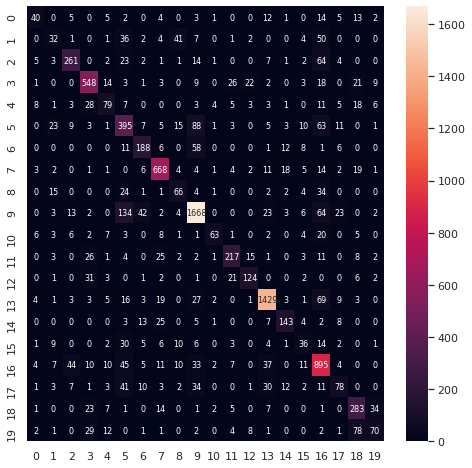

In [163]:
test_data2 = test_data.copy()
#test_data2['ingredient'] = test_data2.ingredients.map(lambda x: ' '.join(x))
df = test_data2[['cuisine','ingredient']]
X = dc_count_vect.transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])
cuisine_test_pred = clf.predict(X) #predict the cuisine based on test data

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, df.cuisine, cv=5)
sum=0
for score in scores:
  sum+= score
print("The goodness of fit of MLP on the test dataset, using cross-validation score is: ", sum/5)
print("The goodness of fit of MLP on the test data set, using normal score is: \t:", clf.score(X, cuisine_test))
from sklearn.metrics import confusion_matrix
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_test, cuisine_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [164]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.53      0.37      0.44       107
     mexican       0.30      0.18      0.22       181
 southern_us       0.74      0.67      0.70       391
      indian       0.78      0.81      0.79       680
      french       0.52      0.43      0.47       185
     chinese       0.51      0.61      0.56       643
        thai       0.66      0.65      0.65       291
cajun_creole       0.83      0.87      0.85       766
    japanese       0.42      0.43      0.43       154
       greek       0.85      0.84      0.84      1989
     spanish       0.79      0.48      0.59       132
      korean       0.73      0.68      0.70       321
     british       0.70      0.64      0.67       194
  vietnamese       0.90      0.89      0.90      1598
    moroccan       0.71      0.68      0.70       211
    filipino       0.34      0.28      0.31       130
       irish       0.66      0.79      0.72      1135
    jamaican       0.49    

Accuracy of this model is :  0.7328436305091568


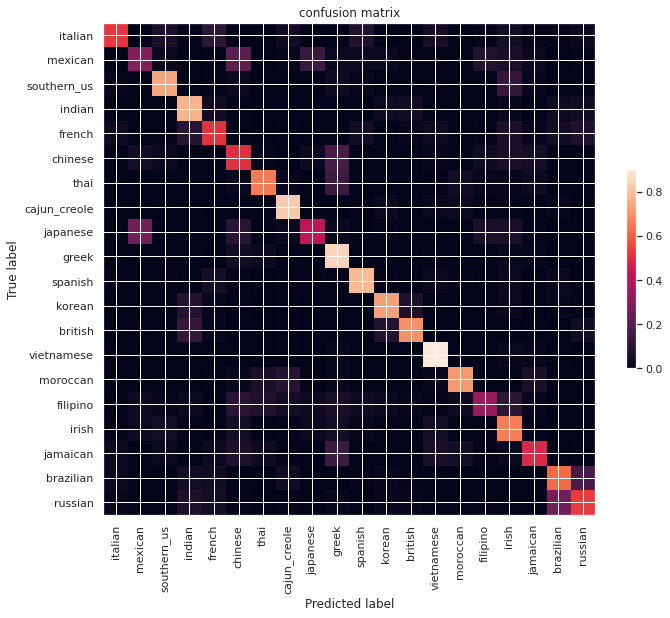

In [165]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of this model is : ", accuracy(cm))

## 5. Logistic Regression

<b>Basic Summary of Logistic Regression</b>
While its name is Logistic Regression, compared to Linear Regression, which is used for regression problems, the Logistic Regression is used for binary classification.

As mentioned, this model is similar to Linear Regression, but uses the probability that a predictor belongs in either 'A' or 'B', and we can see that this actually resembles binary classification.

<b>Further detail on how Logistic Regression Works.</b>

The Logistic Regression model uses something called a sigmoid function. To compare what a sigmoid function is with the Linear Regression model, we can refer to the picture below.

>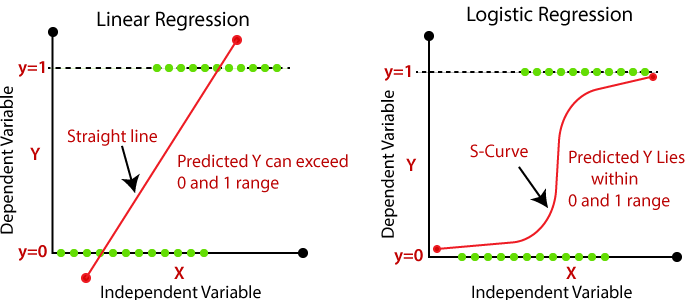

Instead of fitting our data into the linear model, in this section we are using the sigmoid function, as seen by the picture on the right. Our data will be labelled on whether it is true or false based on a variety of predictors. But how can we relate this explanation to our What's Cooking Dataset?


<b>What does it mean for our What's Cooking Dataset?</b>

The Logistic Regression model produces a sigmoid function graph for each cuisine. Then, it iterates each ingredient through this function to check the probability of whether it belongs to that cuisine or not. Here's an example.

We have produced a sigmoid function graph for each cuisine. For this example, let's take 'indian cuisine'.
There is the ingredient of 'chilli powder'. This checks whether there is a higher probability of this ingredient <b>being in</b> indian cuisine, <b>or not</b> being in indian cuisine. 

If there is a higher probability of it being in indian cuisine, it will be 'True'. Otherwise, it will be 'False.' 

The Logistic Regression model does this for each ingredient in each cuisine, then uses it to predict what cuisine a particular dish belongs to.

### Prepare the data

In [166]:
train_data2 = train_data.copy()
#train_data2['ingredient'] = train_data2.ingredients.map(lambda x: ' '.join(x))
df = train_data2[['cuisine','ingredient']]
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

dc_count_vect = CountVectorizer()
dc_tfidf_transformer = TfidfTransformer()
X = dc_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

### Apply Logistic Regression on Train Dataset and evaluate the accuracy

In [167]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logistic, X, df.cuisine, cv=5)
sum=0
for score in scores:
   sum+= score
print("The goodness of fit of model on the train dataset, using cross-validation score is: ", sum/5)
logistic.fit(X, cuisine_train)
cuisine_train_pred = logistic.predict(X)
print("The goodness of fit of logistic regression based on normal score is: ",logistic.score(X, cuisine_train))

The goodness of fit of model on the train dataset, using cross-validation score is:  0.7759031977525728
The goodness of fit of logistic regression based on normal score is:  0.8185019957736558


In [168]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.84      0.54      0.65       360
     mexican       0.71      0.49      0.58       623
 southern_us       0.82      0.72      0.76      1155
      indian       0.82      0.89      0.85      1993
      french       0.83      0.65      0.73       570
     chinese       0.65      0.70      0.67      2001
        thai       0.86      0.72      0.79       883
cajun_creole       0.89      0.93      0.91      2231
    japanese       0.79      0.54      0.64       513
       greek       0.81      0.92      0.86      5847
     spanish       0.93      0.75      0.83       394
      korean       0.89      0.73      0.80      1099
     british       0.89      0.79      0.84       636
  vietnamese       0.92      0.94      0.93      4838
    moroccan       0.90      0.78      0.84       610
    filipino       0.78      0.45      0.57       359
       irish       0.72      0.84      0.78      3184
    jamaican       0.75    

### Apply Logistic Regression on Test Dataset


In [169]:
test_data2 = test_data.copy()
#test_data2['ingredient'] = test_data2.ingredients.map(lambda x: ' '.join(x))
df = test_data2[['cuisine','ingredient']]
X = rf_count_vect.transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = rf_tfidf_transformer.transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])


from sklearn.model_selection import cross_val_score
scores = cross_val_score(logistic, X, df.cuisine, cv=5)
sum=0
for score in scores:
   sum+= score
print("The goodness of fit of model on the train dataset, using cross-validation score is: ", sum/5)

cusine_test_pred = logistic.predict(X)
print("The goodness of fit of logistic regression based on normal score is: ",logistic.score(X, cuisine_test))

The goodness of fit of model on the train dataset, using cross-validation score is:  0.7419009780879541
The goodness of fit of logistic regression based on normal score is:  0.7819480780841216


In [170]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.53      0.37      0.44       107
     mexican       0.30      0.18      0.22       181
 southern_us       0.74      0.67      0.70       391
      indian       0.78      0.81      0.79       680
      french       0.52      0.43      0.47       185
     chinese       0.51      0.61      0.56       643
        thai       0.66      0.65      0.65       291
cajun_creole       0.83      0.87      0.85       766
    japanese       0.42      0.43      0.43       154
       greek       0.85      0.84      0.84      1989
     spanish       0.79      0.48      0.59       132
      korean       0.73      0.68      0.70       321
     british       0.70      0.64      0.67       194
  vietnamese       0.90      0.89      0.90      1598
    moroccan       0.71      0.68      0.70       211
    filipino       0.34      0.28      0.31       130
       irish       0.66      0.79      0.72      1135
    jamaican       0.49    

Accuracy of this model is :  0.7328436305091568


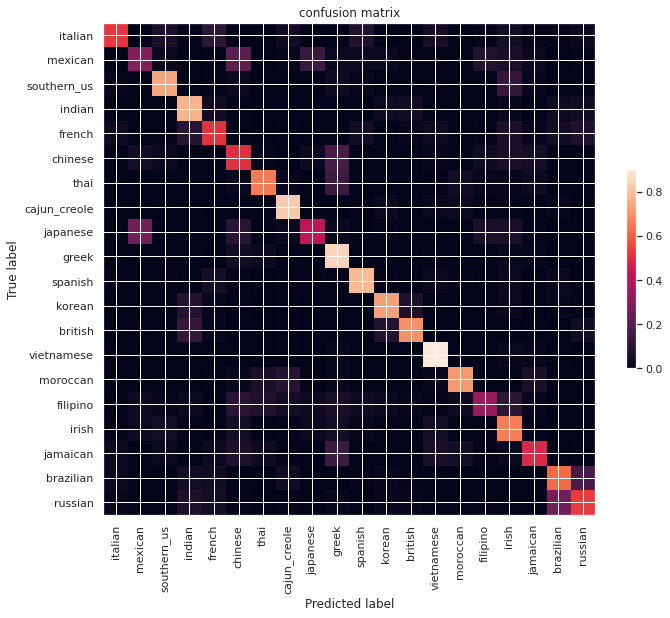

In [171]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of this model is : ", accuracy(cm))

## 6. XGBoost (GradientBoostingClassifier)

We have gone through 2 types of models that use Decision Trees so far.

<ul>
    <li><b>Decision Tree Classifier</b>(Uses a Single Decision Tree)
    <li><b>Random Forest</b></li>(Uses a ensemble of multiple trees, and collates the results at the end.)
    </ul>
    Now, we are going through XGBoost. XGBoost is also using a Decision Tree. However, while Random Forest collates the results at the end of the tree, the XGBoost Model collates the data from the different trees <i>along the way</i>. XGBoost, or GradientBoostingClassifier, is one of the most popular models for data science and analytics competitions like Kaggle.
    
We can observe this in the picture below.
    
> 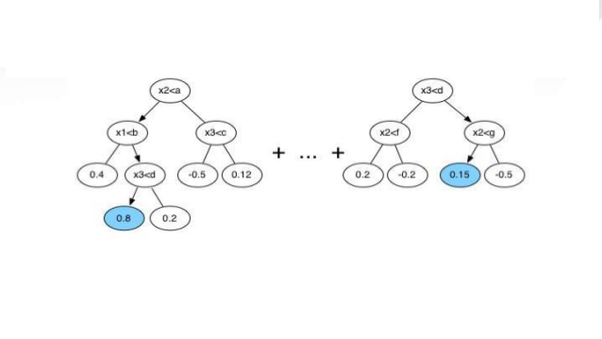
    


In [172]:
train_data2 = train_data.copy()
#train_data2['ingredient'] = train_data2.ingredients.map(lambda x: ' '.join(x))
df = train_data2[['cuisine','ingredient']]
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

dc_count_vect = CountVectorizer()
dc_tfidf_transformer = TfidfTransformer()
X = dc_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

The goodness of fit of model on the train dataset, using cross-validation score is:  0.6528693408075056
The goodness of fit of model on the train data set, using normal score is: 	: 0.7258578472478449


<AxesSubplot:>

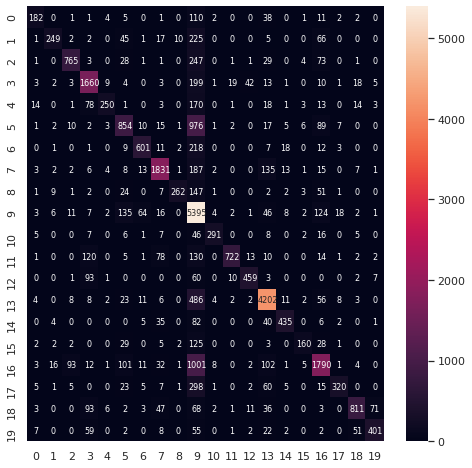

In [173]:
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(0)
model = GradientBoostingClassifier(n_estimators = 5, learning_rate = 0.17, max_depth=5)
model.fit(X, cuisine_train)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, df.cuisine, cv=5)
sum=0
for score in scores:
   sum+= score
print("The goodness of fit of model on the train dataset, using cross-validation score is: ", sum/5)

cuisine_train_pred = model.predict(X)
print("The goodness of fit of model on the train data set, using normal score is: \t:", model.score(X, cuisine_train))
f = plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(cuisine_train, cuisine_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [174]:
print(classification_report(cuisine_train, cuisine_train_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.76      0.51      0.61       360
     mexican       0.85      0.40      0.54       623
 southern_us       0.85      0.66      0.74      1155
      indian       0.77      0.83      0.80      1993
      french       0.89      0.44      0.59       570
     chinese       0.65      0.43      0.52      2001
        thai       0.83      0.68      0.75       883
cajun_creole       0.86      0.82      0.84      2231
    japanese       0.94      0.51      0.66       513
       greek       0.53      0.92      0.67      5847
     spanish       0.92      0.74      0.82       394
      korean       0.95      0.66      0.78      1099
     british       0.86      0.72      0.78       636
  vietnamese       0.88      0.87      0.87      4838
    moroccan       0.87      0.71      0.78       610
    filipino       0.85      0.45      0.58       359
       irish       0.75      0.56      0.64      3184
    jamaican       0.88    

### Test Data

In [175]:
test_data2 = test_data.copy()
#test_data2['ingredient'] = test_data2.ingredients.map(lambda x: ' '.join(x))
df = test_data2[['cuisine','ingredient']]
X = rf_count_vect.transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = rf_tfidf_transformer.transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_test  = pd.DataFrame(df['cuisine'])
ingredient_test = pd.DataFrame(df['ingredient'])

dc_count_vect = CountVectorizer()
dc_tfidf_transformer = TfidfTransformer()
X = dc_count_vect.fit_transform(df.ingredient)#get the word counts for the documents in a sparse matrix form.
X = dc_tfidf_transformer.fit_transform(X)#computing the ti-idf scores for your documents (tf*idf)
cuisine_train  = pd.DataFrame(df['cuisine'])
ingredient_train = pd.DataFrame(df['ingredient'])

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, df.cuisine, cv=5)
sum=0
for score in scores:
   sum+= score
print("The goodness of fit of model on the test dataset, using cross-validation score is: ", sum/5)

The goodness of fit of model on the test dataset, using cross-validation score is:  0.6203470445217859


In [176]:
print(classification_report(cuisine_test, cuisine_test_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.53      0.37      0.44       107
     mexican       0.30      0.18      0.22       181
 southern_us       0.74      0.67      0.70       391
      indian       0.78      0.81      0.79       680
      french       0.52      0.43      0.47       185
     chinese       0.51      0.61      0.56       643
        thai       0.66      0.65      0.65       291
cajun_creole       0.83      0.87      0.85       766
    japanese       0.42      0.43      0.43       154
       greek       0.85      0.84      0.84      1989
     spanish       0.79      0.48      0.59       132
      korean       0.73      0.68      0.70       321
     british       0.70      0.64      0.67       194
  vietnamese       0.90      0.89      0.90      1598
    moroccan       0.71      0.68      0.70       211
    filipino       0.34      0.28      0.31       130
       irish       0.66      0.79      0.72      1135
    jamaican       0.49    

Accuracy of this model is :  0.7328436305091568


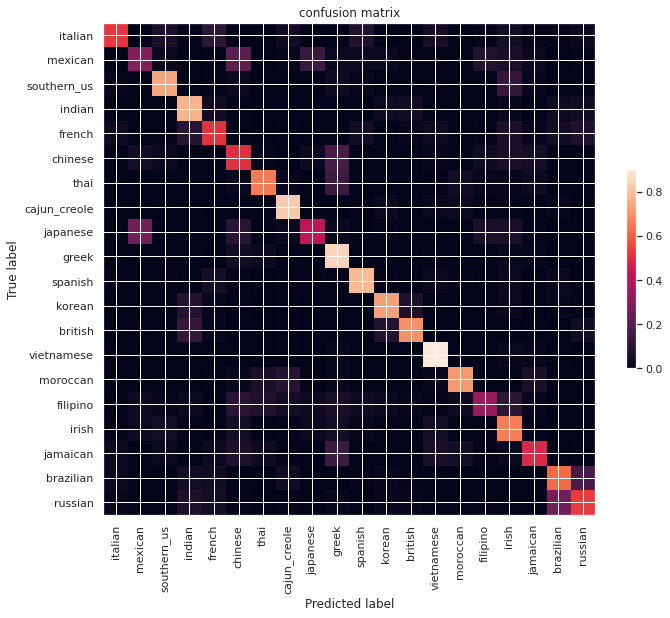

In [177]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cuisine_test_pred, cuisine_test)
plt.figure(figsize=(10, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
cuisines = train_data['cuisine'].value_counts().index
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print("Accuracy of this model is : ", accuracy(cm))